In [ ]:
from pandas_datareader import data as web
import yfinance as yf
from datetime import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_stocks(stocks,start_date='2016-01-01',end_date=datetime.now()):
    
    df_mul = web.DataReader(stocks, 'yahoo', start=start_date, end=end_date) 
    
    df=df_mul["Close"]
    df=df.dropna(axis=1)
    
    return df

In [ ]:
stocks=['AAPL','MSFT','GOOG','AMZN','TSLA','UNH','JNJ','XOM','V']
#stocks=['PETR4.SA','VALE3.SA','ABEV3.SA','ITUB4.SA','WEGE3.SA','BBDC3.SA','BPAC11.SA','ELET3.SA','SANB11.SA','BBAS3.SA']
    
df=get_stocks(stocks)
num_ports = 100000

In [ ]:
log_ret = np.log(df/df.shift(1))

all_weights = np.zeros((num_ports, len(df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(df.columns)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol=vol_arr[sharpe_arr.argmax()]


In [ ]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    #return np.sum(np.abs(weights)) - 1
    return np.sum(weights)-1

def minimize_volatility(weigths):
    return get_ret_vol_sr(weigths)[1]

In [ ]:
cons = ({'type':'eq','fun':check_sum})

bounds=np.tile([(0,1)],(len(df.columns),1))
init_guess =np.tile(0.25,(len(df.columns),1))

from scipy.optimize import minimize
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
print(opt_results)

     fun: -0.953101354134082
     jac: array([-1.19172037e-04, -5.89415431e-05,  2.50985615e-01,  1.81351051e-01,
       -1.61312521e-04,  1.11699104e-04,  4.38798293e-02,  3.22709106e-01,
        1.29244007e-01])
 message: 'Optimization terminated successfully'
    nfev: 80
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([2.45530175e-01, 1.53596374e-01, 0.00000000e+00, 0.00000000e+00,
       1.05476969e-01, 4.95396483e-01, 1.51246203e-17, 6.57568618e-17,
       1.89193279e-17])


In [ ]:
frontier_y = np.linspace(0,0.3,200)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

In [ ]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol=vol_arr[sharpe_arr.argmax()]

min_sr_ret = ret_arr[sharpe_arr.argmin()]
min_sr_vol=vol_arr[sharpe_arr.argmin()]

temp = min(vol_arr)
min_vol_index = [i for i, j in enumerate(vol_arr) if j == temp]

temp = max(ret_arr)
max_ret_index = [i for i, j in enumerate(ret_arr) if j == temp]

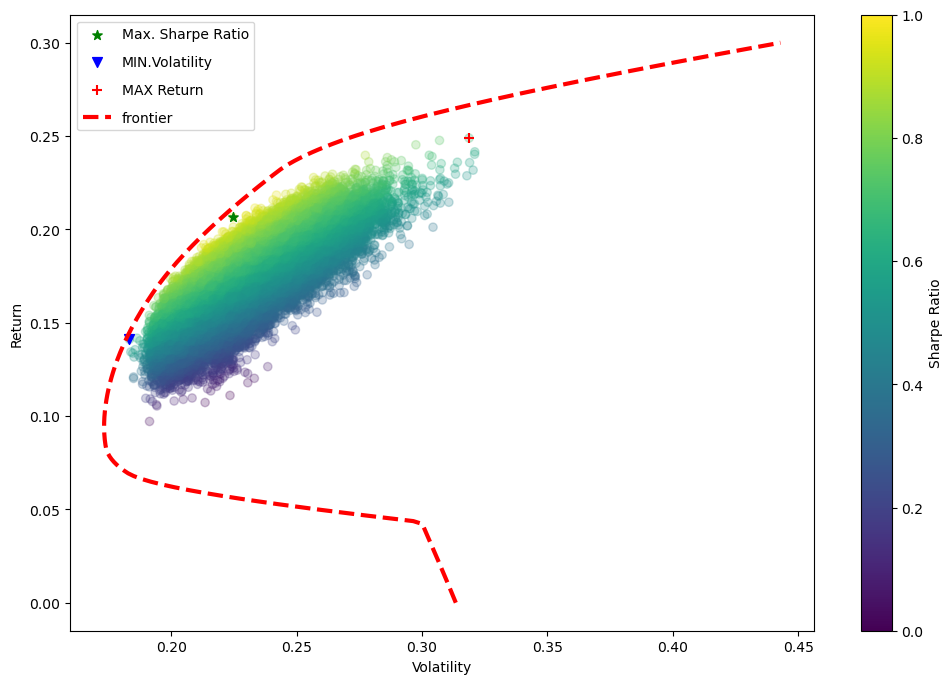

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis',alpha=0.25)
            
plt.scatter(max_sr_vol, max_sr_ret,c='green',marker='*', s=50,label = "Max. Sharpe Ratio") # red dot
plt.scatter(vol_arr[min_vol_index[0]],ret_arr[min_vol_index[0]],c='Blue',marker='v', s=50,label = "MIN.Volatility") # red dot
plt.scatter(vol_arr[max_ret_index[0]],ret_arr[max_ret_index[0]],c='Red',marker='+', s=50,label = "MAX Return") # red dot

plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3,label="frontier")       

plt.legend(labelspacing=1, loc='upper left')


plt.show()

In [ ]:
print('--------------MAX sharpe ratio--------------\n'
      ,'sharpe ratio :{:.4f}'.format(sharpe_arr.max())
      ,'\t volatility:{:.4f}'.format(vol_arr[sharpe_arr.argmax()])
      ,'\t return:{:.4f}'.format(ret_arr[sharpe_arr.argmax()])
      ,'\n-----Stocks-----'
     )
for i ,j in zip(stocks,all_weights[sharpe_arr.argmax(),:]):
    print(i,':{:.4f}'.format(float(j)))
    
        
print('--------------MIN.Volatility--------------\n'
      ,'sharpe ratio :{:.4f}'.format(float(sharpe_arr[min_vol_index[0]]))
      ,'\t volatility:{:.4f}'.format(float(vol_arr[min_vol_index[0]]))
      ,'\t return:{:.4f}'.format(float(ret_arr[min_vol_index[0]]))
      ,'\n-----Stocks-----'
     )

for i ,j in zip(stocks,all_weights[min_vol_index[0],:]):
    print(i,':{:.4f}'.format(float(j)))


print('--------------MAX Return--------------\n'
      ,'sharpe ratio :{:.4f}'.format(float(sharpe_arr[max_ret_index[0]]))
      ,'\t volatility:{:.4f}'.format(float(vol_arr[max_ret_index[0]]))
      ,'\t return:{:.4f}'.format(float(ret_arr[max_ret_index[0]]))
      ,'\n-----Stocks-----'
     )
    
for i ,j in zip(stocks,all_weights[max_ret_index[0],:]):
    print(i,':{:.4f}'.format(float(j)))

--------------MAX sharpe ratio--------------
 sharpe ratio :0.9187 	 volatility:0.2247 	 return:0.2064 
-----Stocks-----
AAPL :0.1518
MSFT :0.1980
GOOG :0.0325
AMZN :0.0097
TSLA :0.1112
UNH :0.3390
JNJ :0.1320
XOM :0.0136
V :0.0122
--------------MIN.Volatility--------------
 sharpe ratio :0.7695 	 volatility:0.1833 	 return:0.1411 
-----Stocks-----
AAPL :0.0867
MSFT :0.0197
GOOG :0.0458
AMZN :0.0748
TSLA :0.0156
UNH :0.2534
JNJ :0.4459
XOM :0.0384
V :0.0198
--------------MAX Return--------------
 sharpe ratio :0.7809 	 volatility:0.3188 	 return:0.2489 
-----Stocks-----
AAPL :0.0425
MSFT :0.0802
GOOG :0.0594
AMZN :0.0003
TSLA :0.4302
UNH :0.2736
JNJ :0.0631
XOM :0.0020
V :0.0488
